# Tree models

In [1]:
# TODO: add clickable list of contents

# TODO: add cross val score for errors
# TODO: update TODO.rmd in branch main
# TODO: think about extremly randomized trees

In [26]:
import os
import sys

from lineartree import LinearTreeRegressor, LinearForestRegressor, LinearBoostRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import xgboost as xgb

In [27]:
sys.path.insert(0, "../..")
import problem

## Load data

In [28]:
X_train, y_train = problem.get_train_data("../..")
X_test, y_test = problem.get_test_data("../..")

## Tree Models

### Basic Random Forest

In [4]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(problem._additional_date_variables)
add_date_cols = ["season"]

drop_cols = [
    "counter_id",
    "site_id",
    "counter_installation_date",
    "counter_technical_id",
]
drop_transformer = FunctionTransformer(
    problem._drop_cols, kw_args={"cols": drop_cols}, validate=False
)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ],
    remainder="passthrough",
)

regressor = RandomForestRegressor(
    max_features="sqrt", verbose=1, n_jobs=4, max_samples=0.5
)

pipe = make_pipeline(
    date_encoder, add_date_encoder, drop_transformer, preprocessor, regressor
)
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.1min finished


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8b319b89d0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8b319b8dc0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _drop_cols at 0x7f8b319b8ee0>,
                                     kw_args={'cols': ['coun...
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features='sqrt', max_samples=0.5,
                                       n_jobs=4, verbose=1))])

In [5]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [6]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.28
Test set, RMSE=0.45


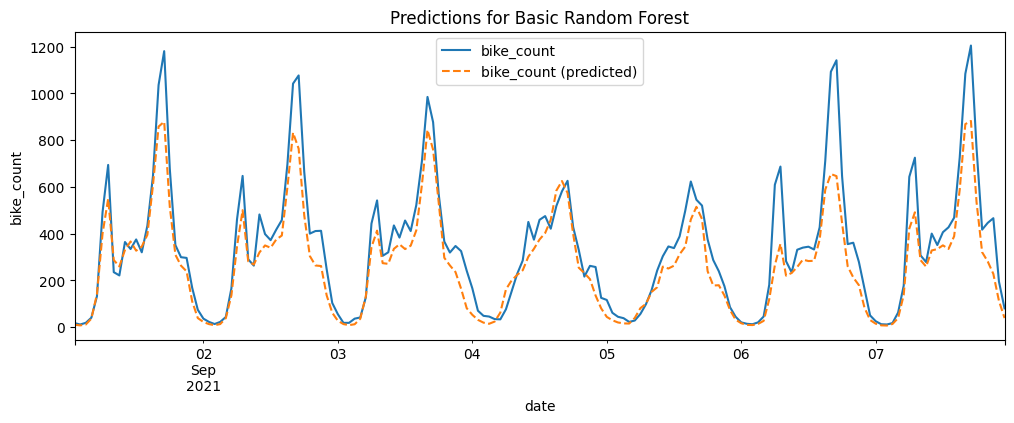

In [7]:
problem.week_plot(X_test, y_pred_test, y_test, "Basic Random Forest")

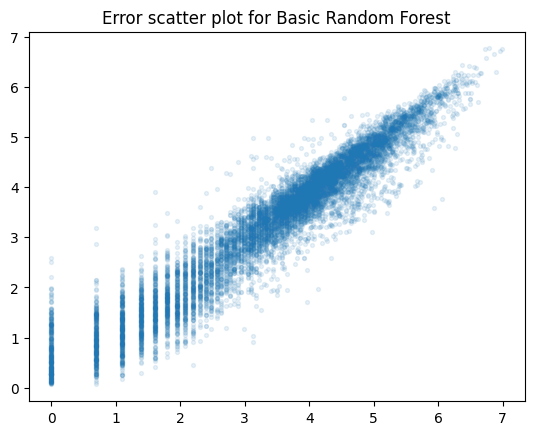

In [8]:
problem.error_plot(y_pred_test, y_test, "Basic Random Forest")

### Random Forest with additional date variables

In [9]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(problem._additional_date_variables)
add_date_cols = ["season"]

drop_cols = [
    "counter_id",
    "site_id",
    "counter_installation_date",
    "counter_technical_id",
]
drop_transformer = FunctionTransformer(
    problem._drop_cols, kw_args={"cols": drop_cols}, validate=False
)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("add_date", OneHotEncoder(handle_unknown="ignore"), add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ],
    remainder="passthrough",
)

regressor = RandomForestRegressor(
    max_features="sqrt", verbose=1, n_jobs=4, max_samples=0.5
)

pipe = make_pipeline(
    date_encoder, add_date_encoder, drop_transformer, preprocessor, regressor
)
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 11.2min finished


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8b319b89d0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8b319b8dc0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _drop_cols at 0x7f8b319b8ee0>,
                                     kw_args={'cols': ['coun...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('add_date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features='sqrt', max_samples=0.5,
                                       n_jobs=4, verbose=1))])

In [10]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [11]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.28
Test set, RMSE=0.45


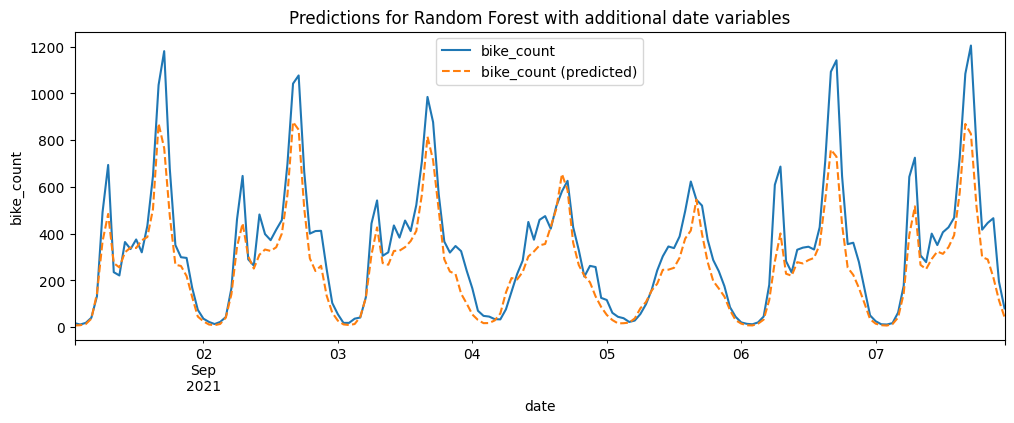

In [12]:
problem.week_plot(
    X_test, y_pred_test, y_test, "Random Forest with additional date variables"
)

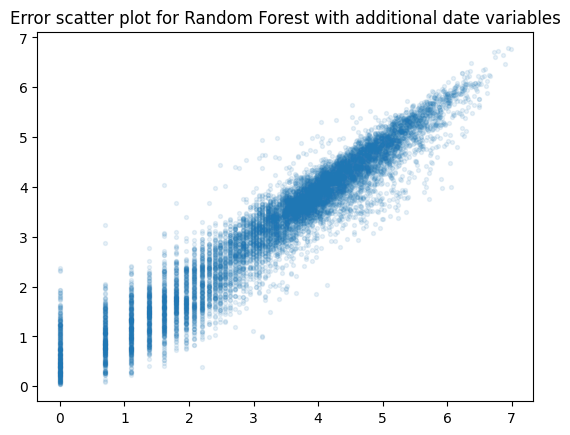

In [13]:
problem.error_plot(y_pred_test, y_test, "Random Forest with additional date variables")

### Random Forest with additional date variables and weather data

In [14]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

drop_cols = [
    "counter_id",
    "site_id",
    "counter_installation_date",
    "counter_technical_id",
]
drop_transformer = FunctionTransformer(
    problem._drop_cols, kw_args={"cols": drop_cols}, validate=False
)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("add_date", OneHotEncoder(handle_unknown="ignore"), add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ],
    remainder="passthrough",
)

regressor = RandomForestRegressor(
    max_features="sqrt", verbose=1, n_jobs=4, max_samples=0.5
)

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    drop_transformer,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 16.0min finished


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8b319b8e50>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8b319b89d0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8b319b8dc0>,
                                     kw_args={'dr...
                                   transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('add_date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features='sqrt', max_samples=0.5,
                                       n_jobs=4, verbose=1))])

In [15]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [16]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.29
Test set, RMSE=0.56


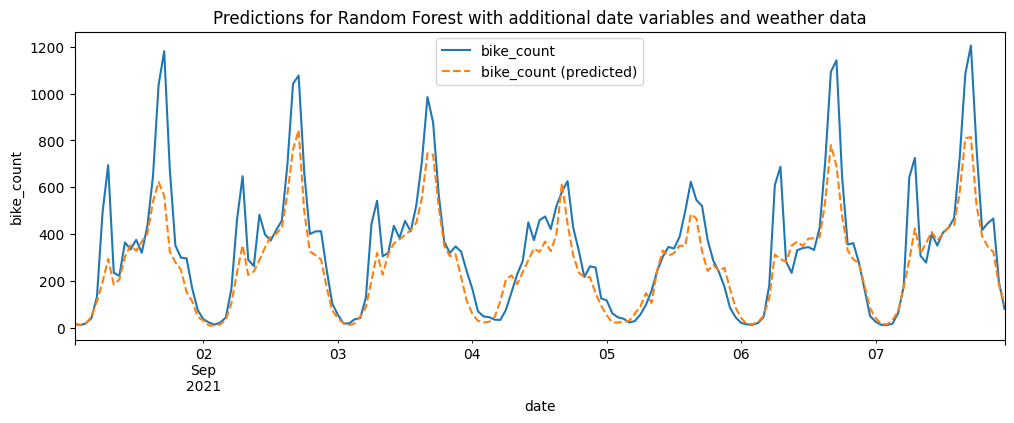

In [17]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Random Forest with additional date variables and weather data",
)

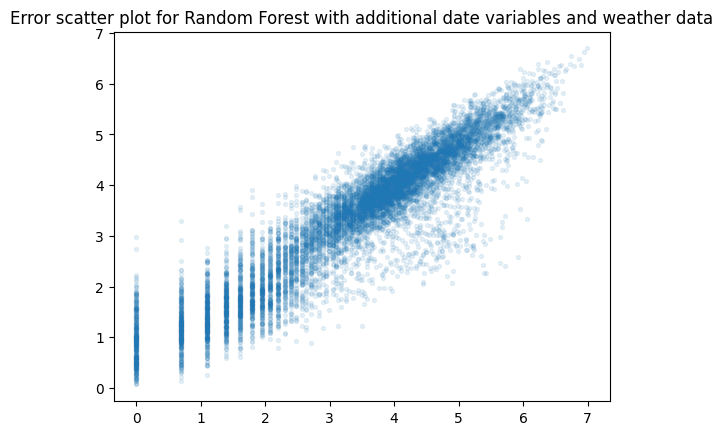

In [18]:
problem.error_plot(
    y_pred_test, y_test, "Random Forest with additional date variables and weather data"
)

In [19]:
# get the depths to have a feeling for tuning
depths = [i.get_depth() for i in pipe["randomforestregressor"].estimators_]
print(min(depths))
print(max(depths))

68
93


### Tuned Random Forest with additional date variables and weather data

First used grid: 

```
# define grid for parameter tuning
    grid = {
        "randomforestregressor__n_estimators": [200, 400],
        "randomforestregressor__max_samples": [0.4, 0.6, 0.8],
        "randomforestregressor__max_depth": [20, 40, 60, 80],
        "randomforestregressor__max_features": ["sqrt", 0.2],
    }
```

After checking the first results in the terminal (since we use the verbose parameter for GridSearchCV), we decided to adjust the grid to the following to limit runtime and finetune a bit more.

```
grid = {
        "randomforestregressor__n_estimators": [300],
        "randomforestregressor__max_samples": [0.4, 0.5, 0.6],
        "randomforestregressor__max_depth": [30, 40],
        "randomforestregressor__max_features": ["sqrt", 0.15, 0.25],
    }
```

In [ ]:
pd.read_csv("./results_tuning/")

### XGB with additional date variables and weather data

In [20]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

drop_cols = [
    "counter_id",
    "site_id",
    "counter_installation_date",
    "counter_technical_id",
]
drop_transformer = FunctionTransformer(
    problem._drop_cols, kw_args={"cols": drop_cols}, validate=False
)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("add_date", OneHotEncoder(handle_unknown="ignore"), add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ],
    remainder="passthrough",
)

regressor = xgb.XGBRegressor()

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    drop_transformer,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8b319b8e50>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8b319b89d0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8b319b8dc0>,
                                     kw_args={'dr...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [21]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

In [22]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.50
Test set, RMSE=0.54


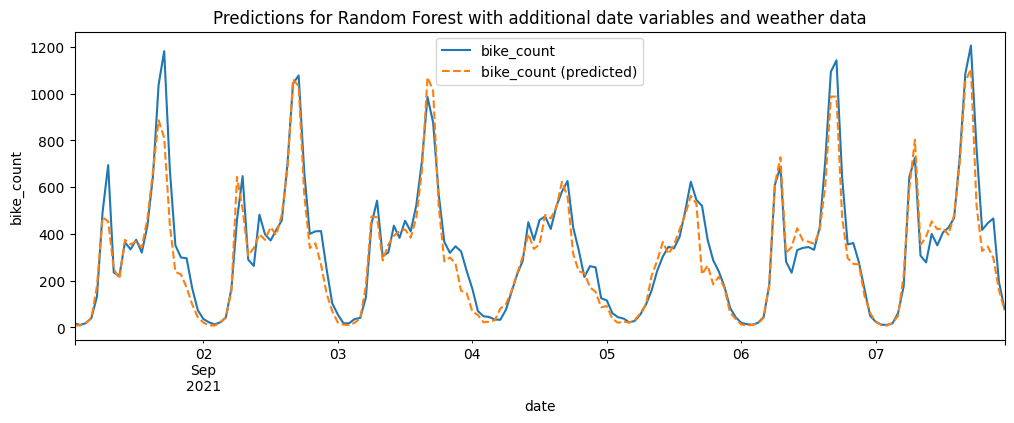

In [23]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Random Forest with additional date variables and weather data",
)

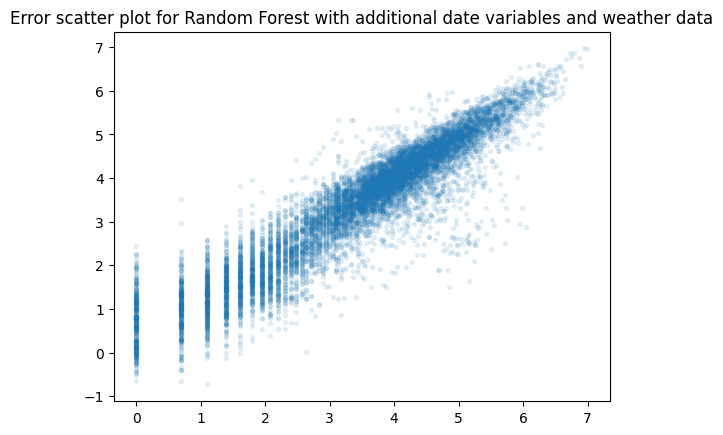

In [24]:
problem.error_plot(
    y_pred_test, y_test, "Random Forest with additional date variables and weather data"
)

### LinearTree with additional date variables and weather data

In [30]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

drop_cols = [
    "counter_id",
    "site_id",
    "counter_installation_date",
    "counter_technical_id",
]
drop_transformer = FunctionTransformer(
    problem._drop_cols, kw_args={"cols": drop_cols}, validate=False
)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ],
    remainder="passthrough", sparse_threshold=0, 
)

regressor = LinearTreeRegressor(base_estimator=Ridge())

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    drop_transformer,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

/Users/mariastoelben/opt/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.76942e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/mariastoelben/opt/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.27191e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/mariastoelben/opt/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.27191e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/mariastoelben/opt/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.76942e-09): result may not be accurat

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8b319b8e50>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8b319b89d0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8b319b8dc0>,
                                     kw_args={'dr...
                                                       'counter_technical_id']})),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('lineartreeregressor',
                 LinearTreeRegressor(base_estimator=Ridge()))])

In [31]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

In [32]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.67
Test set, RMSE=0.88


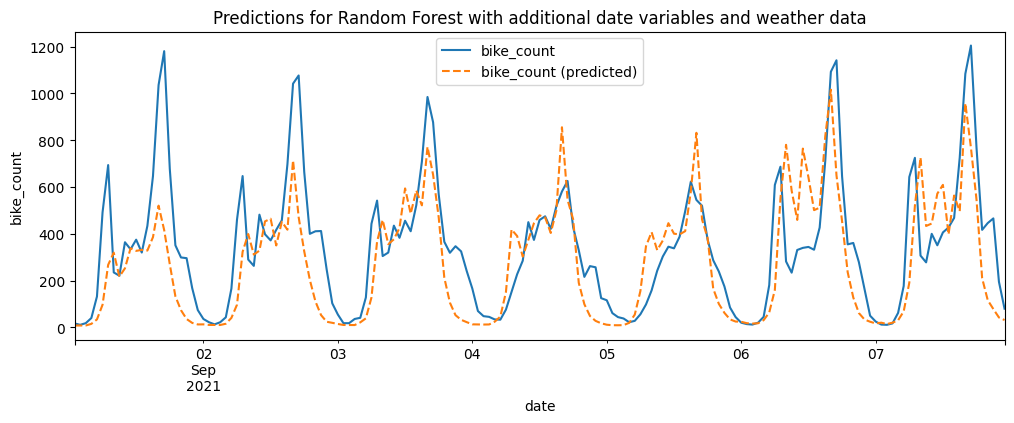

In [33]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Random Forest with additional date variables and weather data",
)

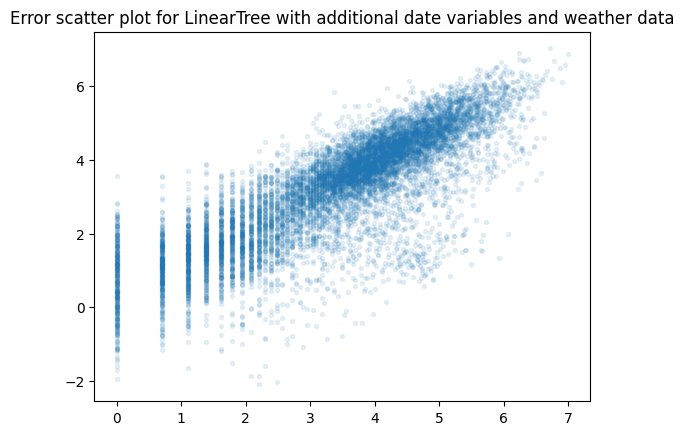

In [34]:
problem.error_plot(
    y_pred_test, y_test, "LinearTree with additional date variables and weather data"
)

### LinearForest with additional date variables and weather data

In [36]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

drop_cols = [
    "counter_id",
    "site_id",
    "counter_installation_date",
    "counter_technical_id",
]
drop_transformer = FunctionTransformer(
    problem._drop_cols, kw_args={"cols": drop_cols}, validate=False
)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ],
    remainder="passthrough",
)

regressor = LinearForestRegressor(base_estimator=Ridge(), max_features="sqrt", max_samples=0.5)

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    drop_transformer,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8b319b8e50>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8b319b89d0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8b319b8dc0>,
                                     kw_args={'dr...
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('linearforestregressor',
                 LinearForestRegressor(base_estimator=Ridge(),
                                       max_features='sqrt', max_samples=0.5))])

In [37]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

In [38]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.27
Test set, RMSE=0.59


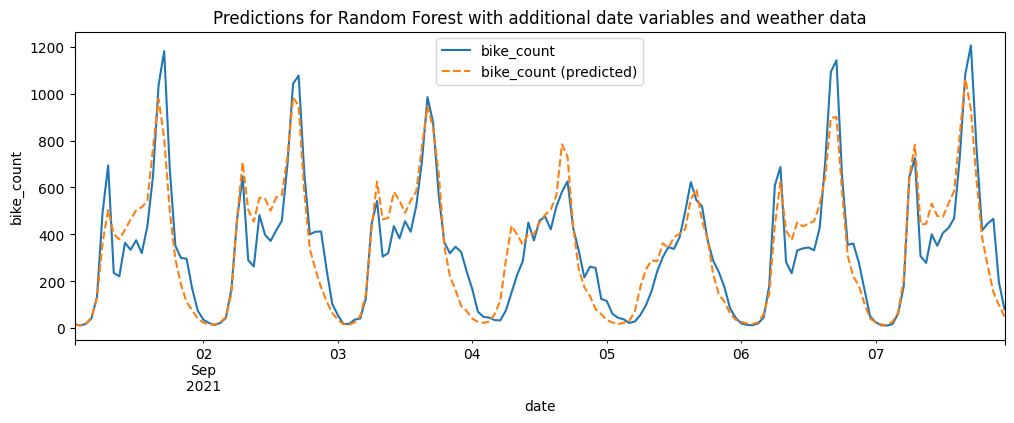

In [39]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Random Forest with additional date variables and weather data",
)

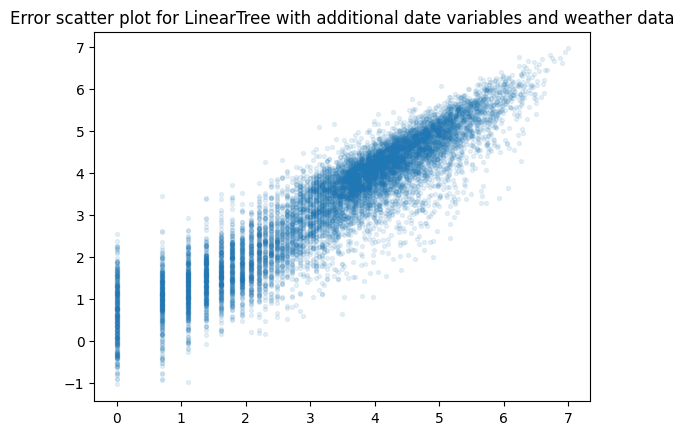

In [40]:
problem.error_plot(
    y_pred_test, y_test, "LinearTree with additional date variables and weather data"
)

### LinearBoosting with additional date variables and weather data

In [42]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

drop_cols = [
    "counter_id",
    "site_id",
    "counter_installation_date",
    "counter_technical_id",
]
drop_transformer = FunctionTransformer(
    problem._drop_cols, kw_args={"cols": drop_cols}, validate=False
)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("add_date", OneHotEncoder(handle_unknown="ignore"), add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ],
    remainder="passthrough",
)

regressor = LinearBoostRegressor(base_estimator=Ridge())

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    drop_transformer,
    preprocessor,
    FunctionTransformer(lambda X: X.todense()),
    regressor,
)
pipe.fit(X_train, y_train)

/Users/mariastoelben/opt/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8b319b8e50>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8b319b89d0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8b319b8dc0>,
                                     kw_args={'dr...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('add_date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function <lambda> at 0x7f8af2511f70>)),
                ('linearboostregressor',
                 LinearBoostRegressor(base_estimator=Ridge()))])

In [43]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

/Users/mariastoelben/opt/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/mariastoelben/opt/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [44]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.77
Test set, RMSE=0.77


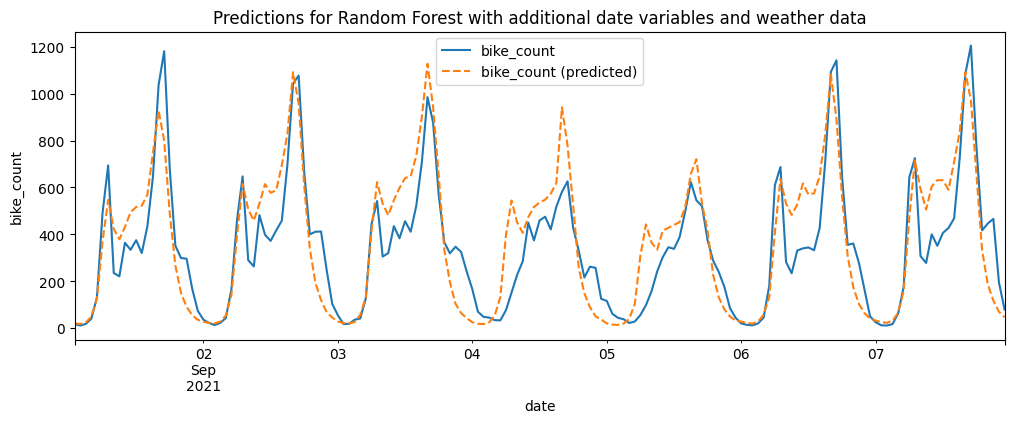

In [45]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Random Forest with additional date variables and weather data",
)

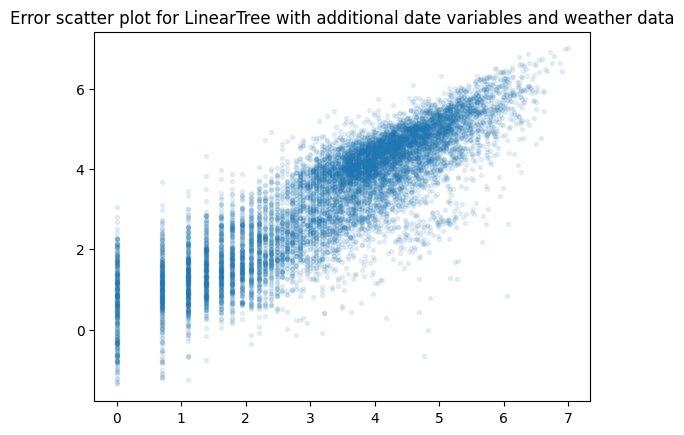

In [46]:
problem.error_plot(
    y_pred_test, y_test, "LinearTree with additional date variables and weather data"
)